In [0]:
#今為mobileNetV2示範 heatmap辨識位置(標示CNN學習位置,多用於事後檢驗)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

import cv2
from keras import backend as K
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications.mobilenet_v2 import preprocess_input
from matplotlib import pyplot as plt
import numpy as np
import random

import keras
from glob import glob
from tqdm.auto import tqdm
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from keras.models import load_model
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


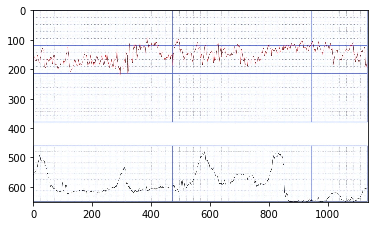

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(199imgs)/*/*.jpg'  
img_path = glob(data_path)
img = cv2.imread(img_path[0])
plt.imshow(img)

In [0]:
def processing_image(img_path):
    img = cv2.imread(img_path)[:,:,::-1]  
    img = cv2.resize(img, (224,224))
    x = np.expand_dims(img, axis=0)
    
    # 影像前處理: 轉換為 BGR，並解減去各通道平均
    x = preprocess_input(x)
    return x

In [0]:
#gradcam模型: 吃一個模型然後吃一張圖
def gradcam(model, x):                                                          
    # 取得影像的分類類別:先讓model進行預測,得最高機率的分類類別
    preds = model.predict(x)
    pred_class = np.argmax(preds[0])

    # 取得影像分類名稱
    pred_class_name = keras.utils.to_categorical(preds, num_classes=2)

    # 預測分類的輸出向量
    pred_output = model.output[:, pred_class]                                   #把pred_class帶入pre-train好的模型

    # 最後一層 convolution layer 輸出的 feature map                               
    # 今為分析ResNet 的最後一層 convolution layer                                 
    last_conv_layer = model.get_layer('Conv_1')
    
    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    grads = K.gradients(pred_output, last_conv_layer.output)[0]                 

    # 求得針對每個 feature map 的梯度加總: 今K為Keras內建底層tensorflow
    pooled_grads = K.sum(grads, axis=(0, 1, 2))                                 

    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])   

    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])                  

    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性    
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
        
    # 計算 feature map 的 channel-wise 加總                                      
    heatmap = np.sum(conv_layer_output_value, axis=-1)

    return heatmap, pred_class_name


In [0]:
def plot_heatmap(heatmap, img_path, pred_class_name):
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # 正規化
    heatmap /= np.max(heatmap)
    
    # 讀取影像                                                                   
    img = cv2.imread(img_path)
    
    fig, ax = plt.subplots()
    
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))

    # 拉伸 heatmap
    print(heatmap.shape)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)
    
    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    
    plt.title(pred_class_name)
    
    plt.show()

In [0]:
model = load_model(os.path.join(data_path, '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/HC-MobileNetV2-2-val_loss0.000-val_acc1.00.h5'))














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
img_path = '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(199imgs)/fullOK/OK_demo0124full_60549600-8-007.jpg'      
img_path

'/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(199imgs)/fullOK/OK_demo0124full_60549600-8-007.jpg'

In [0]:
cls = img_path.split('/')[-2]
cls

'fullOK'

(7, 7)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


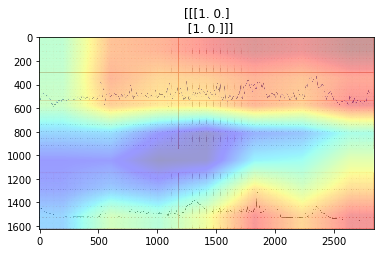

In [0]:
img = processing_image(img_path)                                                #把圖讀出來                              
heatmap, cls = gradcam(model, img)                                                                          
plot_heatmap(heatmap, img_path, cls)